In [1]:
import shapely
import random
import numpy as np
from shapely.geometry import Point, LineString
from shapely.ops import split, substring
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy

In [2]:
def properly_split_lines(line, point, return_connection=False):

    ''' 
    line: LineString
    point: Point
    return_connection: bool, default: False
    This function:
        1. finds the connection (=shortest line) from point to line; 
        2. snaps the intersection (end coordinate of the connection) to line;
        3. splits line at intersection
        4. returns list of: split linestrings AND (if return_connection=True) connection linestring
    '''

    # will start on point and end on line - but (assuming worst case) vertex on line does not exist yet
    connection = shapely.shortest_line(point, line) # order matters!
    
    # by definition, 2nd point of connection is the one "on" the line
    point2snap = Point(connection.coords[1]) 

    line_snapped = shapely.snap(
        line,
        point2snap,
        tolerance = 10**-6 # must be small! (<<1)
    )
    lines_split = list(split(line_snapped, point2snap).geoms)
    if return_connection:
        lines_split += [connection]
    
    # assertions to make sure that all lines now intersect in exactly one and the same point
    gdf = gpd.GeoDataFrame(geometry=lines_split)    
    intersections = []
    for i, row in gdf.iterrows():
        for _, row2 in gdf.drop(labels = i, axis = 0).iterrows():
            intersections.append(row.geometry.intersection(row2.geometry))
    assert all([type(p)==shapely.geometry.point.Point for p in intersections]), "Intersection type unequal Point"
    assert len(set(intersections))==1, "Intersection count unequal 1"

    return lines_split

point:  POINT (0.2946650026871097 0.5305867556052941)
connection:  LINESTRING (0.2946650026871097 0.5305867556052941, 0.4750323543040182 0.3480640959278061)
intersection:  LINESTRING EMPTY


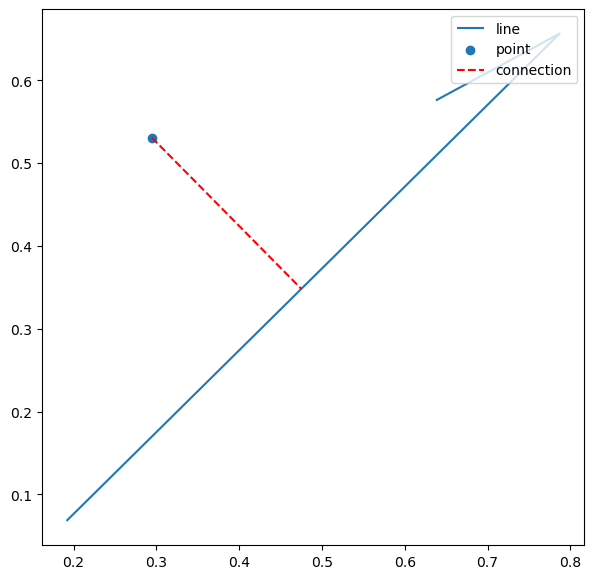

In [3]:
np.random.seed(17)
a, b, c, d = [np.random.uniform(0,1,size=2) for i in range(4)]
point = Point(a)
line = LineString([b,c,d])
connection = shapely.shortest_line(point, line) # will start on point and end on line - but vertex on line does not exist yet
intersection = shapely.intersection(line, connection)
print("point: ", point)
print("connection: ", connection)
print("intersection: ", intersection)
fig, ax = plt.subplots(1,1, figsize = (7,7))
gpd.GeoDataFrame({"geometry": [line]}).plot(ax=ax, label = "line")
gpd.GeoDataFrame({"geometry": [point]}).plot(ax=ax, label = "point")
gpd.GeoDataFrame({"geometry": [connection]}).plot(ax=ax, label = "connection", color = "red", linestyle = "--")
if intersection:
    gpd.GeoDataFrame({"geometry": [intersection]}).plot(ax=ax, label = "intersection", color = "red")
#ax.set_axis_off()
ax.legend();

point to snap: POINT (0.4750323543040182 0.3480640959278061)
line snapped:  LINESTRING (0.1915207869474949 0.0679003581912914, 0.4750323543040182 0.3480640959278061, 0.7869854599999133 0.6563335217758555, 0.6375208960436358 0.575602893753034)
intersection snapped:  POINT (0.4750323543040182 0.3480640959278061)


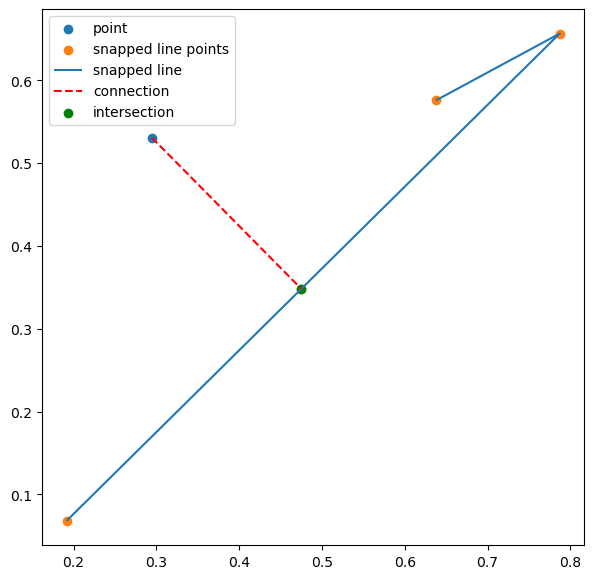

In [4]:
point2snap = Point(connection.coords[1])
print("point to snap:", point2snap)
line_snapped = shapely.snap(line, point2snap, tolerance = 10**-6)
print("line snapped: ", line_snapped)
intersection_snapped = shapely.intersection(line_snapped, connection)
print("intersection snapped: ", intersection_snapped)
fig, ax = plt.subplots(1,1, figsize = (7,7))
gpd.GeoDataFrame({"geometry": [point]}).plot(ax=ax, label = "point")
gpd.GeoDataFrame({"geometry": [Point(c) for c in line_snapped.coords]}).plot(ax=ax, label = "snapped line points")
gpd.GeoDataFrame({"geometry": [line_snapped]}).plot(ax=ax, label = "snapped line")
gpd.GeoDataFrame({"geometry": [connection]}).plot(ax=ax, label = "connection", color = "red", linestyle = "--")
if intersection_snapped:
    gpd.GeoDataFrame({"geometry": [intersection_snapped]}).plot(ax=ax, label = "intersection", color = "green")
ax.legend();

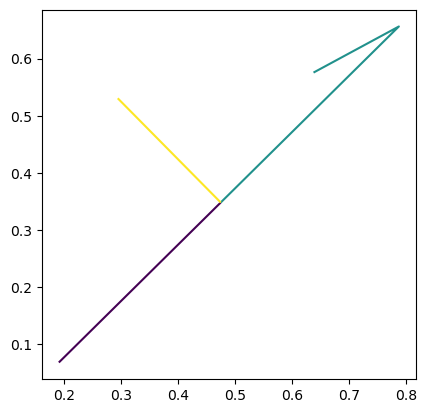

In [5]:
lines_split = [l for l in split(line_snapped, point2snap).geoms]
gdf = gpd.GeoDataFrame({"geometry": lines_split + [connection]})
gdf["r"] = gdf.index
gdf.plot(column="r");

In [6]:
intersections = []
for i, row in gdf.iterrows():
    for _, row2 in gdf.drop(labels = i, axis = 0).iterrows():
        intersections.append(row.geometry.intersection(row2.geometry))
assert all([type(p)==shapely.geometry.point.Point for p in intersections])
assert len(set(intersections))==1

<Axes: >

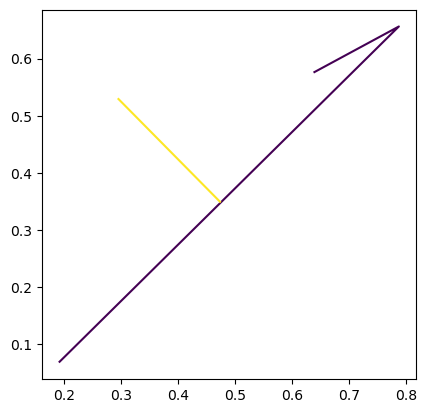

In [7]:
stroke_gdf = momepy.COINS(gdf).stroke_gdf()
stroke_gdf["stroke"] = stroke_gdf.index
stroke_gdf.plot(column="stroke")

**Test if function returns expected output**

<Axes: >

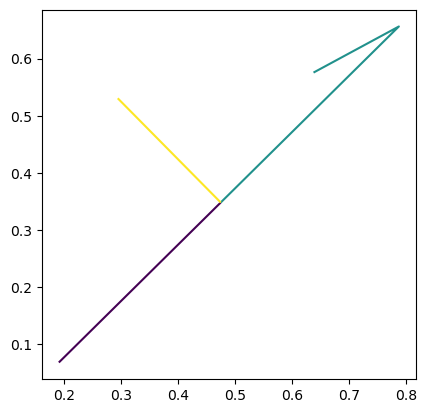

In [8]:
mylines = properly_split_lines(line, point, True)
gpd.GeoDataFrame({"geometry": mylines, "r":range(len(mylines))}).plot(column="r")